# PH21B007

# Prasid

# Helium Atom

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm                                
from numba import njit
import math
from matplotlib.ticker import FormatStrFormatter

To run this file numpy, pandas, matplotlib, tqdm, numba these libraries are needed.

If you are getting module not found kind of error then write ! pip install lib_name at the top of the file before importing the lbraries.

e.g. ! pip install numpy

In [2]:
# Setting Matplotlib plotting defaults
# Font
mpl.rcParams['font.family']           ='Serif'    # Setting Font family
mpl.rcParams['font.size']             = 18        # Setting Font size
# Figure
mpl.rcParams["figure.figsize"]        = (11, 7)   # Setting Figure size nearly equal to A4 sheet size
mpl.rcParams['savefig.dpi']           = 300       # Setting plot quality
mpl.rcParams['figure.dpi']            = 300       # High resolution for print quality
# Legend
mpl.rcParams["legend.fontsize"]       = 15        # Legend fontsize
mpl.rcParams["legend.title_fontsize"] = 15        # Legend fontsize
# Grid
mpl.rcParams["axes.grid"]             = True      # Setting grid to display
mpl.rcParams["grid.color"]            ='black'    # Setting grid color
mpl.rcParams['grid.linestyle']        ='--'       # Setting grid linestyle
mpl.rcParams['grid.linewidth']        = 0.5       # Setting grid linewidth
mpl.rcParams['grid.color']            ='gray'     # Setting grid color as gray
# xticks
mpl.rcParams["xtick.minor.visible"]   = True      # Setting visibility of xticks
mpl.rcParams['xtick.minor.width']     = 1.0       # Setting width of minor xticks
mpl.rcParams['xtick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['xtick.direction']       ='inout'    # Setting directions of xticks
mpl.rcParams['xtick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['xtick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['xtick.top']             = True      # Setting visibility of top minor xticks
# yticks
mpl.rcParams["ytick.minor.visible"]   = True      # Setting visibility of yticks
mpl.rcParams['ytick.minor.width']     = 1.0       # Setting width of minor yticks
mpl.rcParams['ytick.major.width']     = 1.0       # Setting width of major xticks
mpl.rcParams['ytick.direction']       ='inout'    # Setting directions of yticks
mpl.rcParams['ytick.minor.size']      = 5         # Setting size of minor xticks
mpl.rcParams['ytick.major.size']      = 8         # Setting size of major xticks
mpl.rcParams['ytick.right']           = True      # Setting visibility of top minor xticks

## Trial Wavefunction 

In [3]:
@njit() # trial wave functions

# trial trial wave function without cusp condition: psi = e^(-a*(r_1 + r_2))
def psi_t(r, a):
    c = 0.0  
    for i in range(2): # Loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        c += math.sqrt(dis)  # calculating the distance
    return math.exp(-c * a)                            

@njit()
# trial trial wave function without cusp condition: psi = e^(-a*(r_1 + r_2)) * e^(r_12 / 2)
def psi_tc(r, a):
    c = 0.0  
    for i in range(2): # Loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        c += math.sqrt(dis)  # calculating the distance
    
    # Calculate r_12 (distance between electrons)
    r_12 = 0.0
    for j in range(3): # Loop over x, y, z          
        r_12 += (r[0,j] - r[1,j])**2
    r_12 = math.sqrt(r_12)  # This was missing
    
    return math.exp(-c * a) * math.exp(r_12/2)


## Local Energy

In [4]:
@njit() # local energy calculations using the central difference method on trial wave function

def local_energy(r, a, psi):
    h = 0.001  # Step size for numerical derivative
    h2 = 1/(h**2)
    
    psi_c = psi(r, a) # current wave function 
    
    r_f = np.copy(r)
    r_b = np.copy(r)
    
    ke = 0.0  # kinetic energy calculation
    for i in range(2):  # Loop over electrons
        for d in range(3):  # Loop over x, y, z
            
            r_f[i][d] += h   # forward +h
            psi_f = psi(r_f, a)
            r_f[i][d] -= h
            
            r_b[i][d] -= h  # backward -h
            psi_b = psi(r_b, a)
            r_b[i][d] += h
            
            ke += (psi_f + psi_b - 2 * psi_c) * h2  # central difference for del**2(psi)/del(r**2)
    
    ke = -0.5 * ke / psi_c # in atomic units: KE = -0.5 * del2(psi) / psi
    
    pe = 0.0 # Potential energy
    
    # Electron-nucleus interaction
    for i in range(2): # Loop over electrons
        dis = 0.0
        for j in range(3): # Loop over x, y, z
            dis += r[i,j]**2
        pe -= 2 / math.sqrt(dis)  
    
    # Electron-electron interaction
    for k in range(2-1):
        for m in range(k+1, 2):  # Loop over electron pair
            r_12 = 0.0
            for j in range(3): # Loop over x, y, z          
                r_12 += (r[k,j] - r[m,j])**2
            pe += 1.0 / math.sqrt(r_12)

    return ke + pe # total energy

## Variational Monte Carlo

In [5]:
@njit() # function to perform the monte carlo swip

def mc_swip(r, a, s, psi):
    rand_pos = np.random.rand(2, 3)
    r_new = r + s * (rand_pos - 0.5)    # propose new positions for both electrons
    
    psi_old = psi(r, a)
    psi_new = psi(r_new, a)
    ratio = (psi_new / psi_old)**2  # acceptance probability
    
    if np.random.rand() < ratio:   # Metropolis Algorithm
        return r_new 
    else:
        return r

In [6]:
# function to do the monte carlo iterations and store the necessary quantities
@njit(fastmath=True)
def vmc(a, n, n_th, s, psi):
    r = np.random.rand(2, 3) * s - s/2    # initialize electrons randomly
    
    for i in range(int(n_th)):  # thermalization
        r = mc_swip(r, a, s, psi)
    
    e_local = np.zeros(int(n), dtype=np.float64)    
    for i in range(n):                        # Monte carlo sampling
        r = mc_swip(r, a, s, psi)
        e_local[i] = local_energy(r, a, psi)
        
    e_mean = np.mean(e_local) # taking the mean of local energy over all the n iterations
    e_var = np.var(e_local)   # variance of local energy
    
    return e_mean, e_var

In [7]:
# scanning alpha around the expected minimum (~ 1.75)
a_val = np.arange(1, 2.02, 0.05)    # a values
s = 1.0                             # step length
n_th = 1e3                          # thermalization iterations
n = 1e7                             # no. of monte carlo iterations

energy = []  # empty lists to store the values
var = []

for a in tqdm(a_val):  # loop over all alpha values
    e, v = vmc(a, n, n_th, s, psi_t)
    energy.append(e)
    var.append(v)
    
# exact local energy 
e_exact = [z**2 - 4*z + 5/8 * z for z in a_val]

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [05:02<00:00, 14.40s/it]


In [8]:
# Find optimal alphas for energy and variance.
opt_alpha_en = a_val[np.argmin(energy)]
print(f"Optimal α = {opt_alpha_en:.2f}, Energy = {np.min(energy):.6f} (in atomic units) or {2*13.6*np.min(energy):.6f} (in eV)")

opt_alpha_var = a_val[np.argmin(var)]
print(f"Optimal α = {opt_alpha_var:.2f}, Variance = {np.min(var):.6f} (in atomic units)")

Optimal α = 1.70, Energy = -2.848553 (in atomic units) or -77.480647 (in eV)
Optimal α = 1.85, Variance = 0.829409 (in atomic units)


A total of $10^7$ Monte Carlo moves were used with a step length of 1 Bohr radius. 

The variance at the minimum is 0.8289409, reflecting the fact that we do not have
the exact wave function. The variance has a minimum at value of $\alpha$ different from the energy minimum.

If we wish to convert these energies into more familiar units like electronvolt (eV), we have to multiply our reults
with $2E_0$ where $E_0$ = 13.6 eV, the binding energy of the hydrogen atom. Using $\psi_T = e^{-\alpha(r_1 + r_2)}$
trial wave function, we obtain an energy minimum at $\alpha$ = 1.70. The ground state is E = −2.85 in
atomic units or E = −77.48 eV. The experimental value is −78.8 eV.

In [9]:
# scanning alpha around the expected minimum (~ 1.75)
a_val_c = np.arange(1.35, 2.45, 0.05)    # a values
s = 1.0                             # step length
n_th = 1e3                          # thermalization iterations
n = 1e7                             # no. of monte carlo iterations

energy_c = []  # empty lists to store the values
var_c = []

for a in tqdm(a_val_c):  # loop over all alpha values
    e, v = vmc(a, n, n_th, s, psi_tc)
    energy_c.append(e)
    var_c.append(v)
    
# exact local energy 
# e_exact_c = [z**2 - 4*z + 5/8 * z for z in a_val]

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [05:25<00:00, 14.80s/it]


In [18]:
# Find optimal alphas for energy and variance.
opt_alpha_en_c = a_val_c[np.argmin(energy_c)]
print(f"Optimal α = {opt_alpha_en_c:.2f}, Energy = {np.min(energy_c):.6f} (in atomic units) or {2*13.6*np.min(energy_c):.6f} (in eV)")

opt_alpha_var_c = a_val_c[np.argmin(var_c)]
print(f"Optimal α = {opt_alpha_var_c:.2f}, Variance = {np.min(var_c):.6f} (in atomic units)")

Optimal α = 2.05, Energy = -2.857333 (in atomic units) or -77.719465 (in eV)
Optimal α = 2.00, Variance = 0.241019 (in atomic units)


A total of $10^7$ Monte Carlo moves were used with a step length of 1 Bohr radius. 

The variance at the minimum is 0.241019, reflecting the fact that we do not have
the exact wave function, but we can see significant improvement from non-cusp condition. The variance has a minimum at value of $\alpha$ different from the energy minimum. 

If we wish to convert these energies into more familiar units like electronvolt (eV), we have to multiply our reults
with $2E_0$ where $E_0$ = 13.6 eV, the binding energy of the hydrogen atom. Using $\psi_T = e^{-\alpha(r_1 + r_2)}e^{r_{12}/2}$
trial wave function, we obtain an energy minimum at $\alpha$ = 2.05. The ground state is E = −2.86 in
atomic units or E = −77.72 eV. The experimental value is −78.8 eV.

## Plots

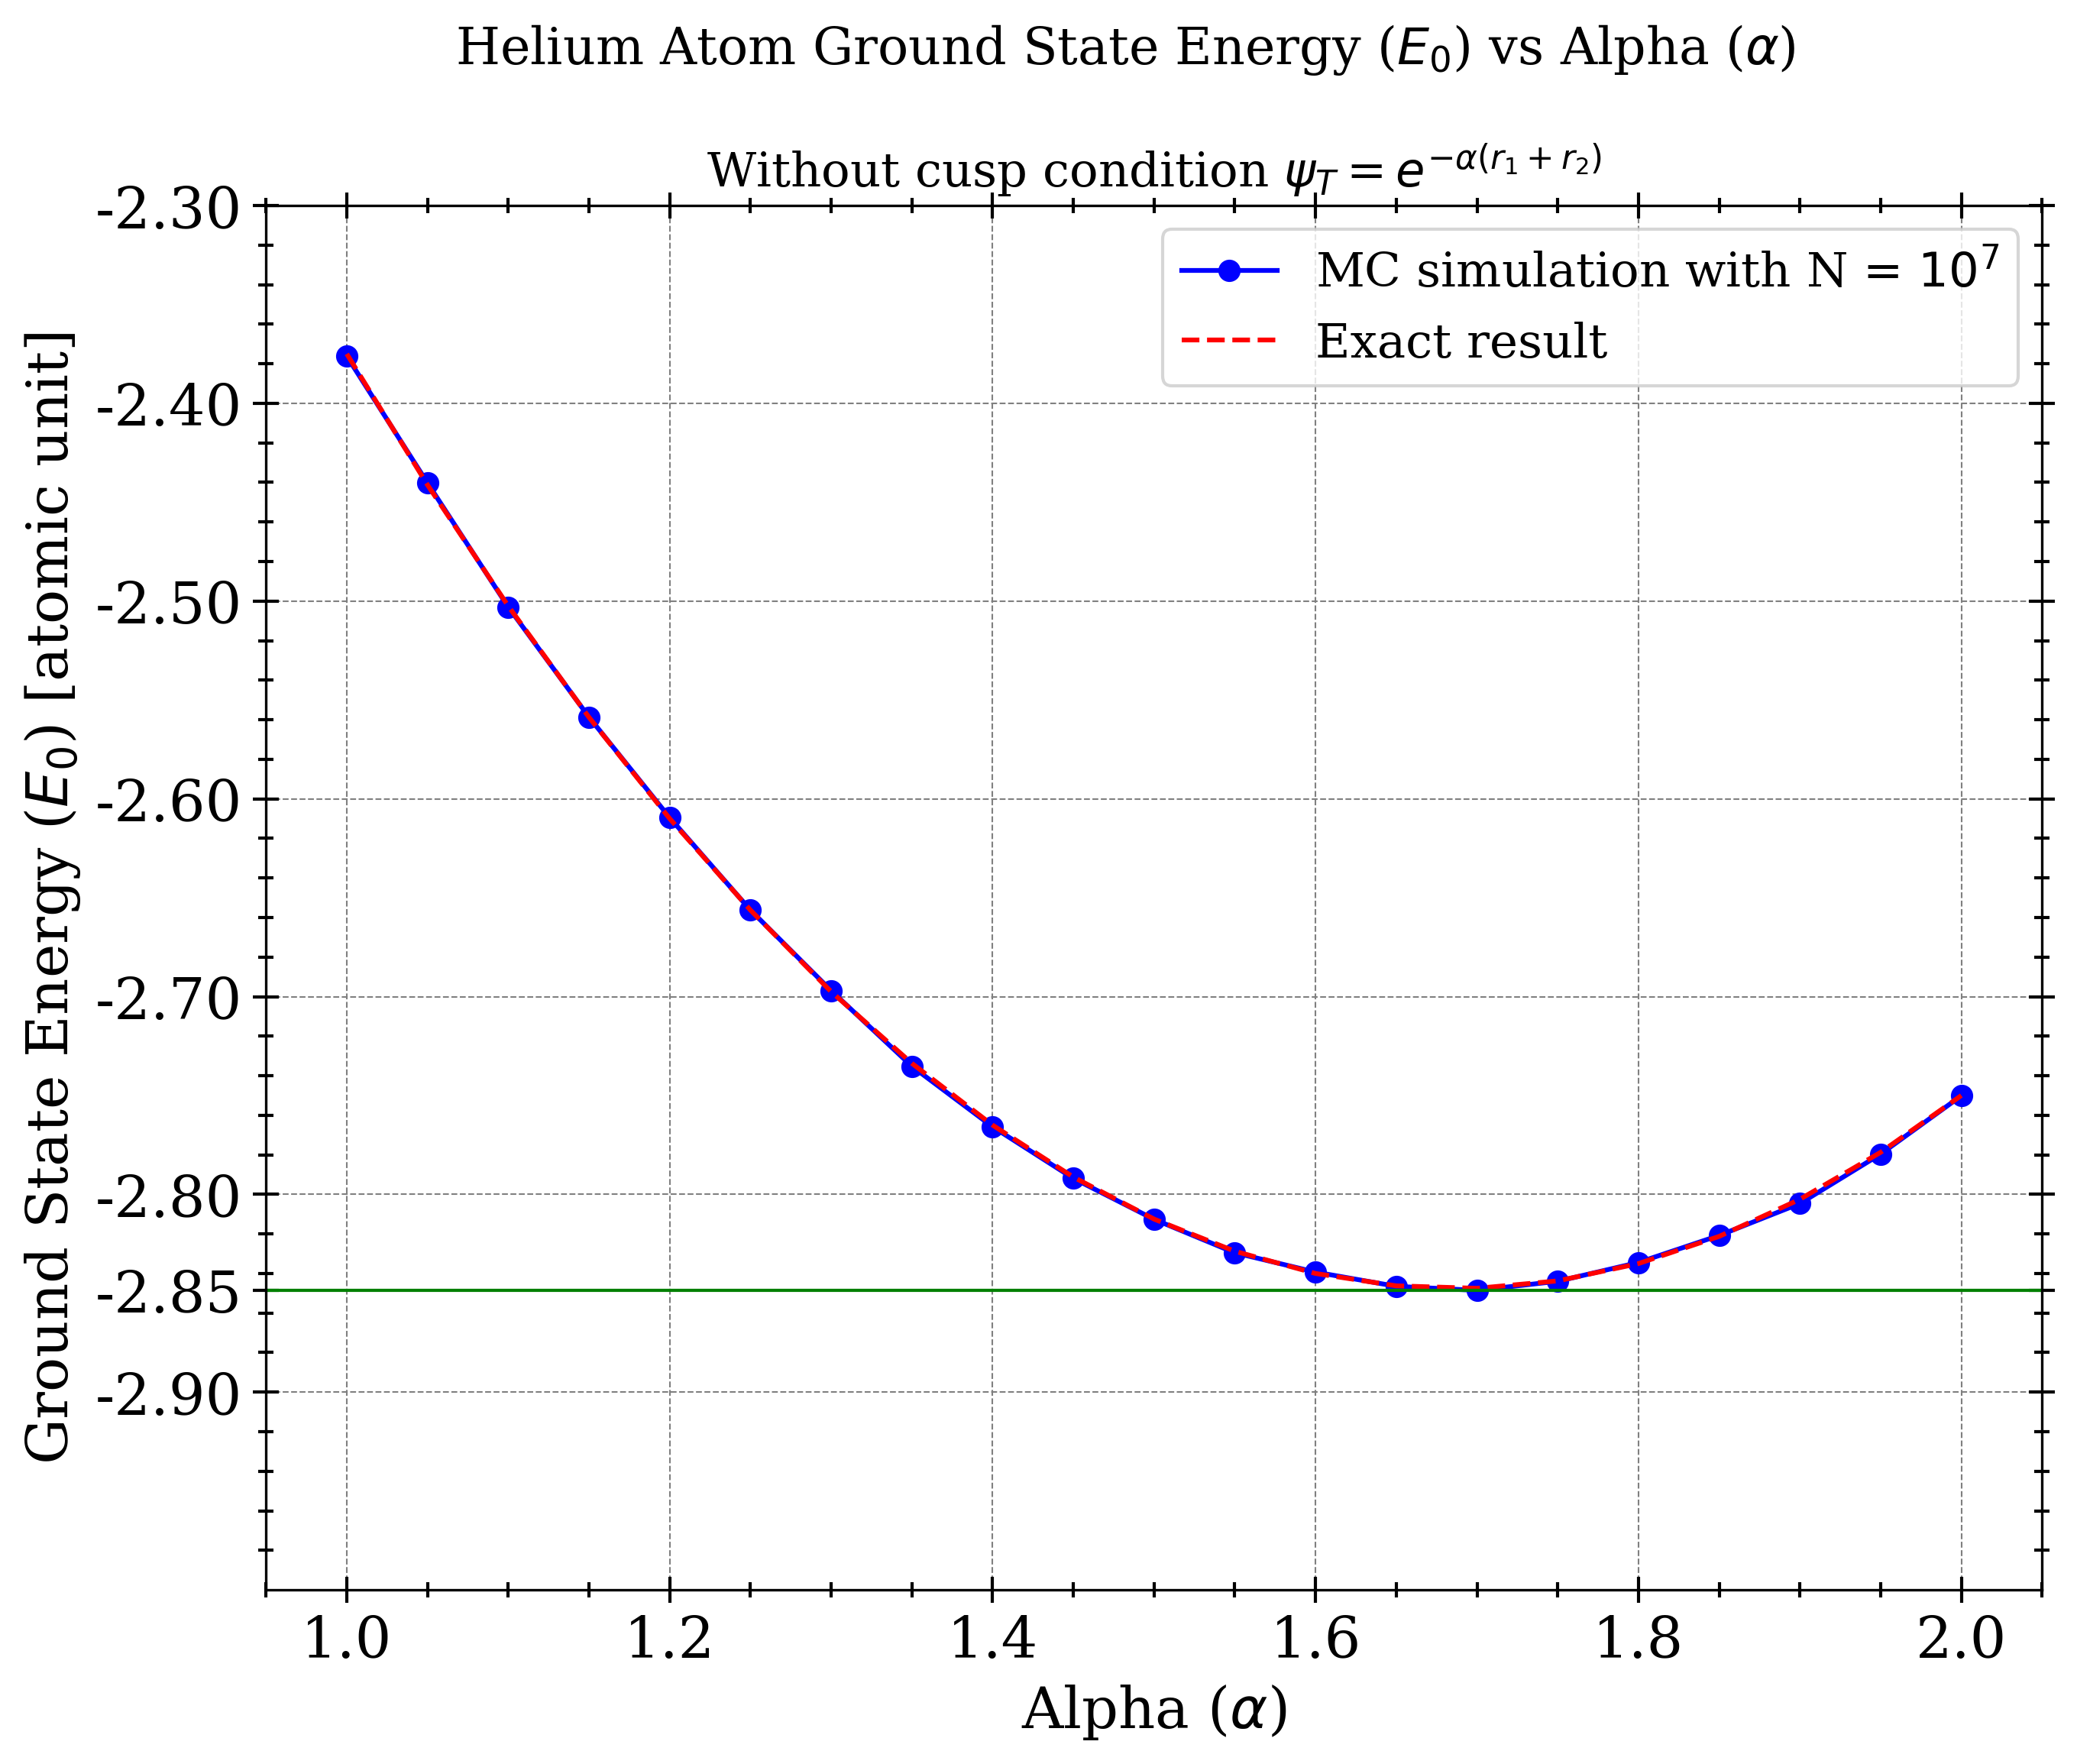

In [11]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.plot(a_val, energy, 'bo-', label = r'MC simulation with N = $10^7$')
plt.plot(a_val, e_exact, 'r--', label = 'Exact result')
plt.xlabel(r'Alpha ($\alpha$)')
plt.ylabel(r'Ground State Energy ($E_{0}$) [atomic unit]')
plt.suptitle('Helium Atom Ground State Energy ($E_0$) v/s Alpha ($\\alpha$)', fontsize=16)
plt.title('Without cusp condition $\\psi_T = e^{-\\alpha(r_1 + r_2)}$', fontsize=15)
# plt.title(r'Helium Atom Ground State Energy ($E_{0}$) v/s Alpha ($\alpha$)',fontsize=16)
plt.axhline(y = np.min(energy), color='g', linestyle='-', linewidth=1)
plt.yticks(list(plt.yticks()[0]) + [np.min(energy)])  # Update ticks
plt.ylim(-3,-2.3)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend()
plt.grid(True)

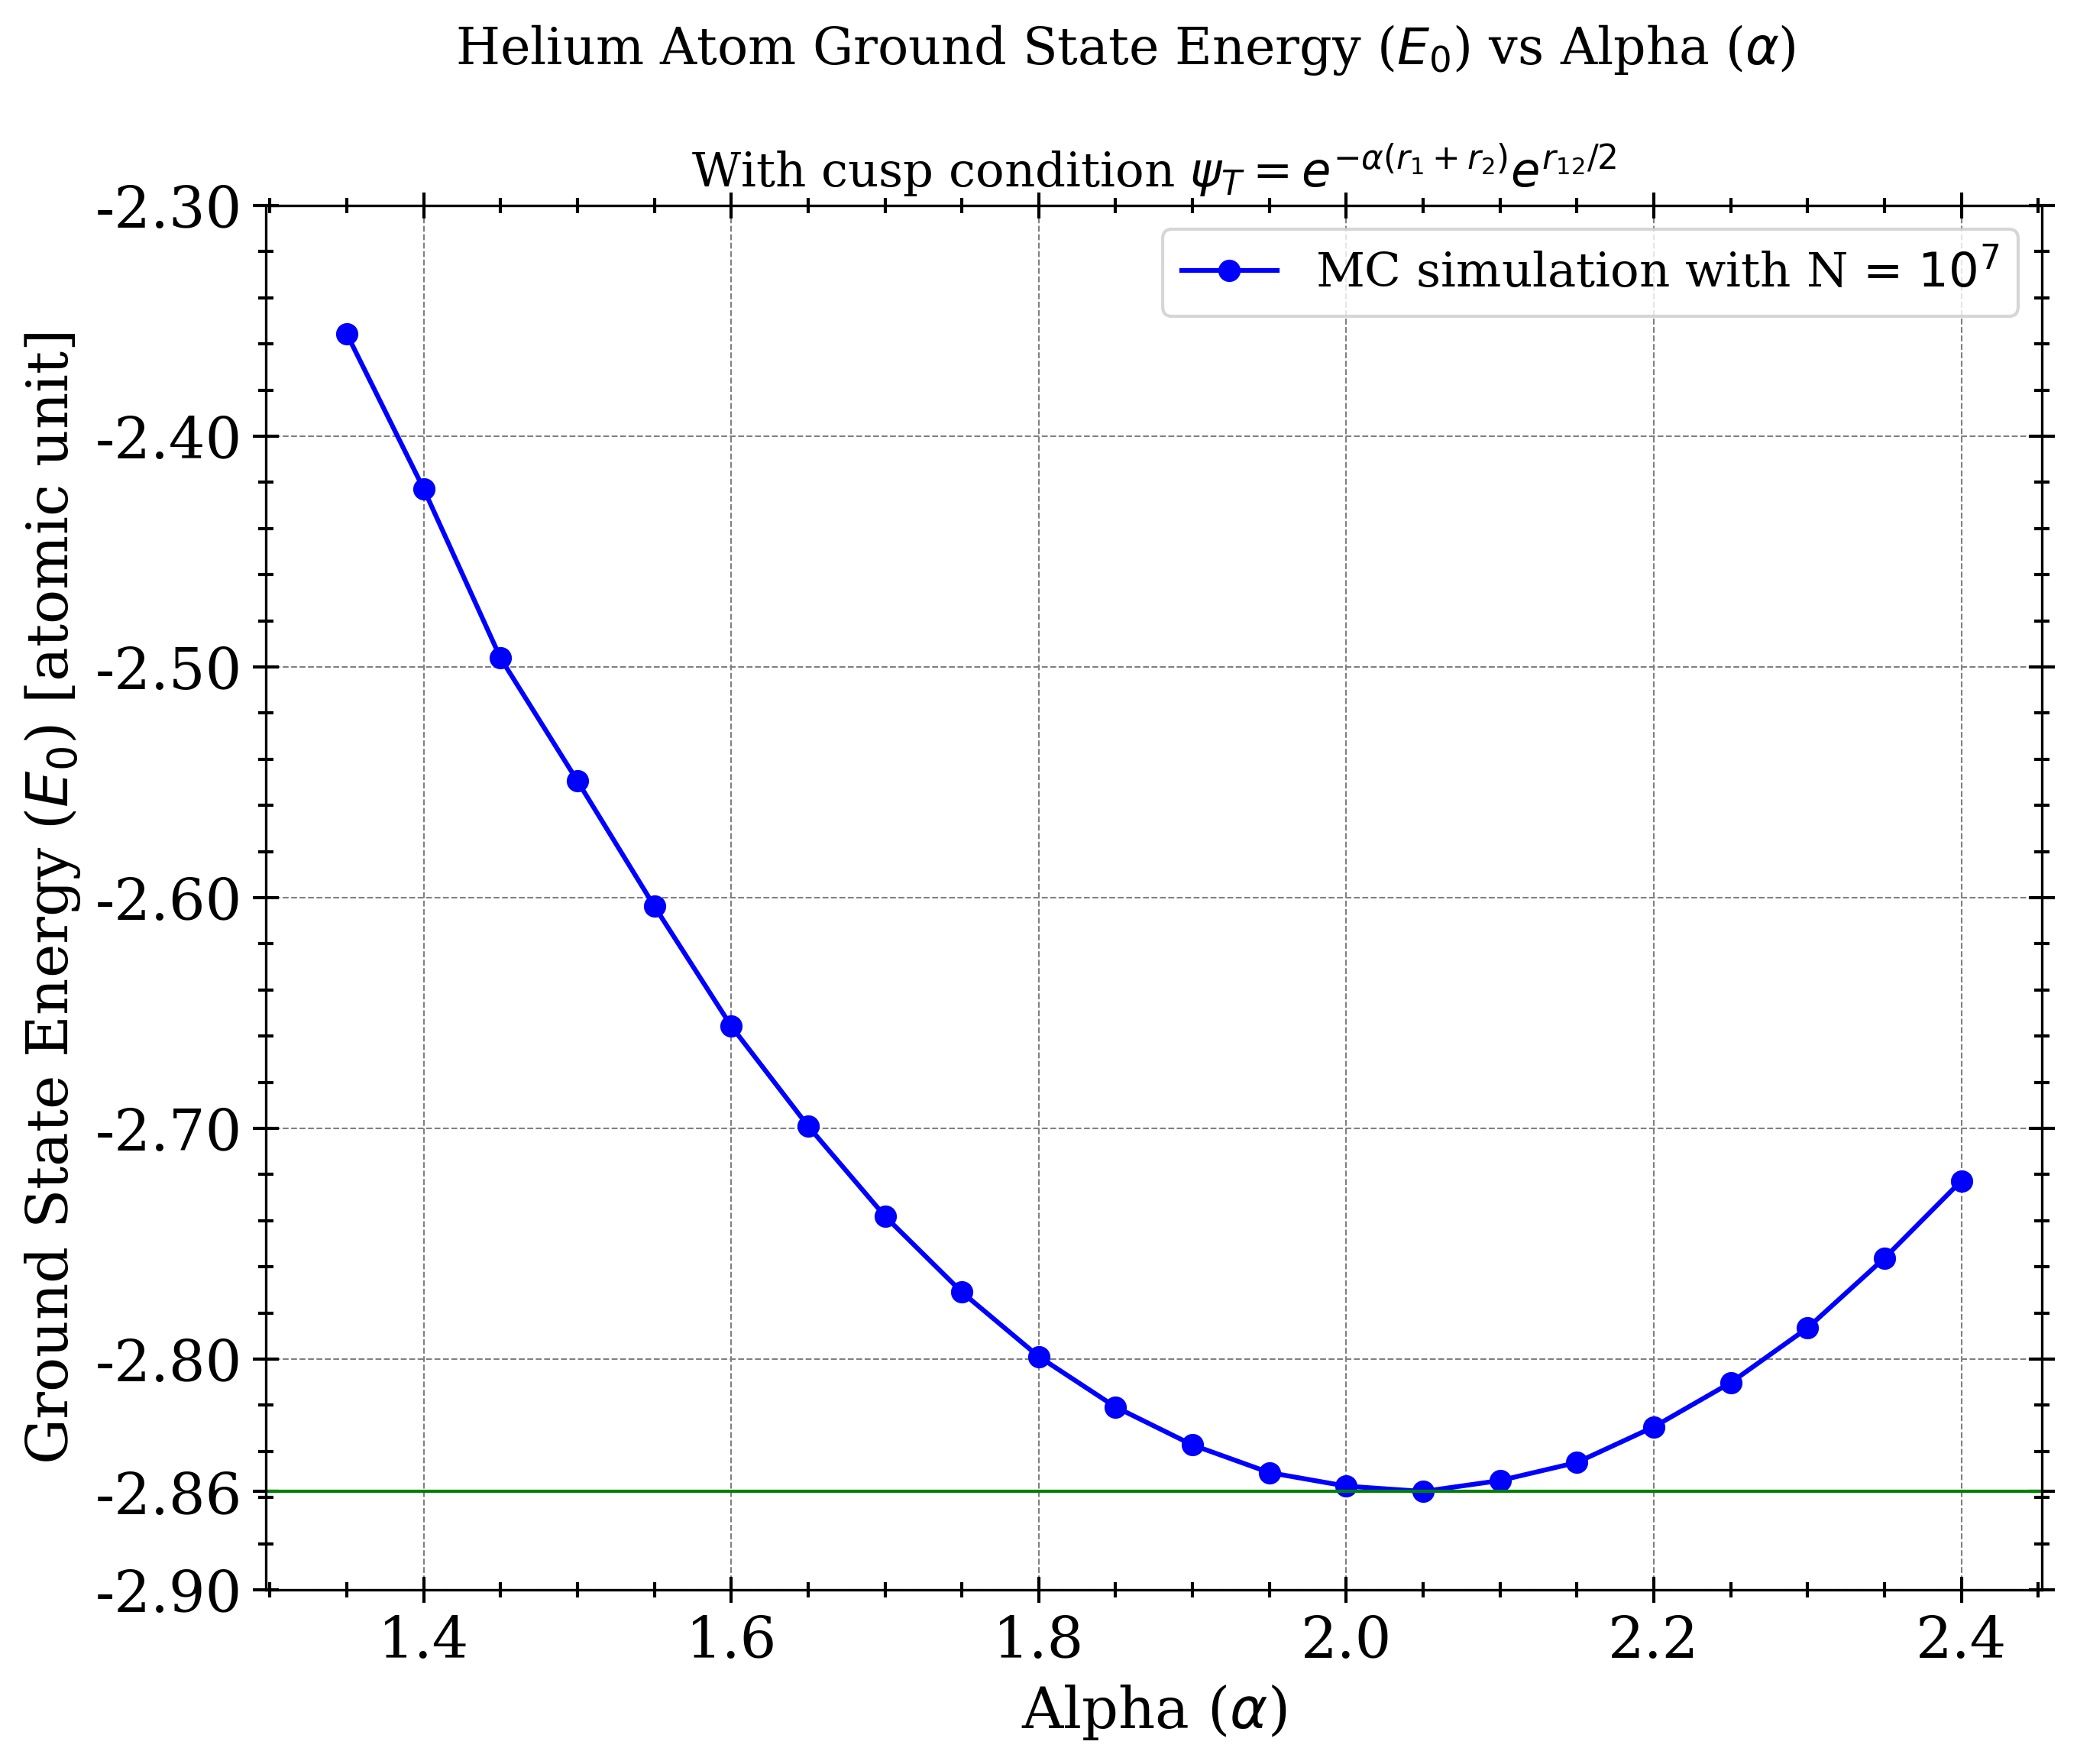

In [12]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.plot(a_val_c, energy_c, 'bo-', label = r'MC simulation with N = $10^7$')
# plt.plot(a_val_c, e_exact_c, 'r--', label = 'Exact result')
plt.xlabel(r'Alpha ($\alpha$)')
plt.ylabel(r'Ground State Energy ($E_{0}$) [atomic unit]')
plt.suptitle('Helium Atom Ground State Energy ($E_0$) v/s Alpha ($\\alpha$)', fontsize=16)
plt.title('With cusp condition $\\psi_T = e^{-\\alpha(r_1 + r_2)} e^{r_{12}/2}$', fontsize=15)
# plt.title(r'Helium Atom Ground State Energy ($E_{0}$) v/s Alpha ($\alpha$) \n With cusp condition $\psi_{T} = e^{-\alpha*(r_{1}+r_{2})} * e^{r_{12}/2}$',fontsize=16)
plt.axhline(y = np.min(energy_c), color='g', linestyle='-', linewidth=1)
plt.yticks(list(plt.yticks()[0]) + [np.min(energy_c)])  # Update ticks
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend()
plt.grid(True)

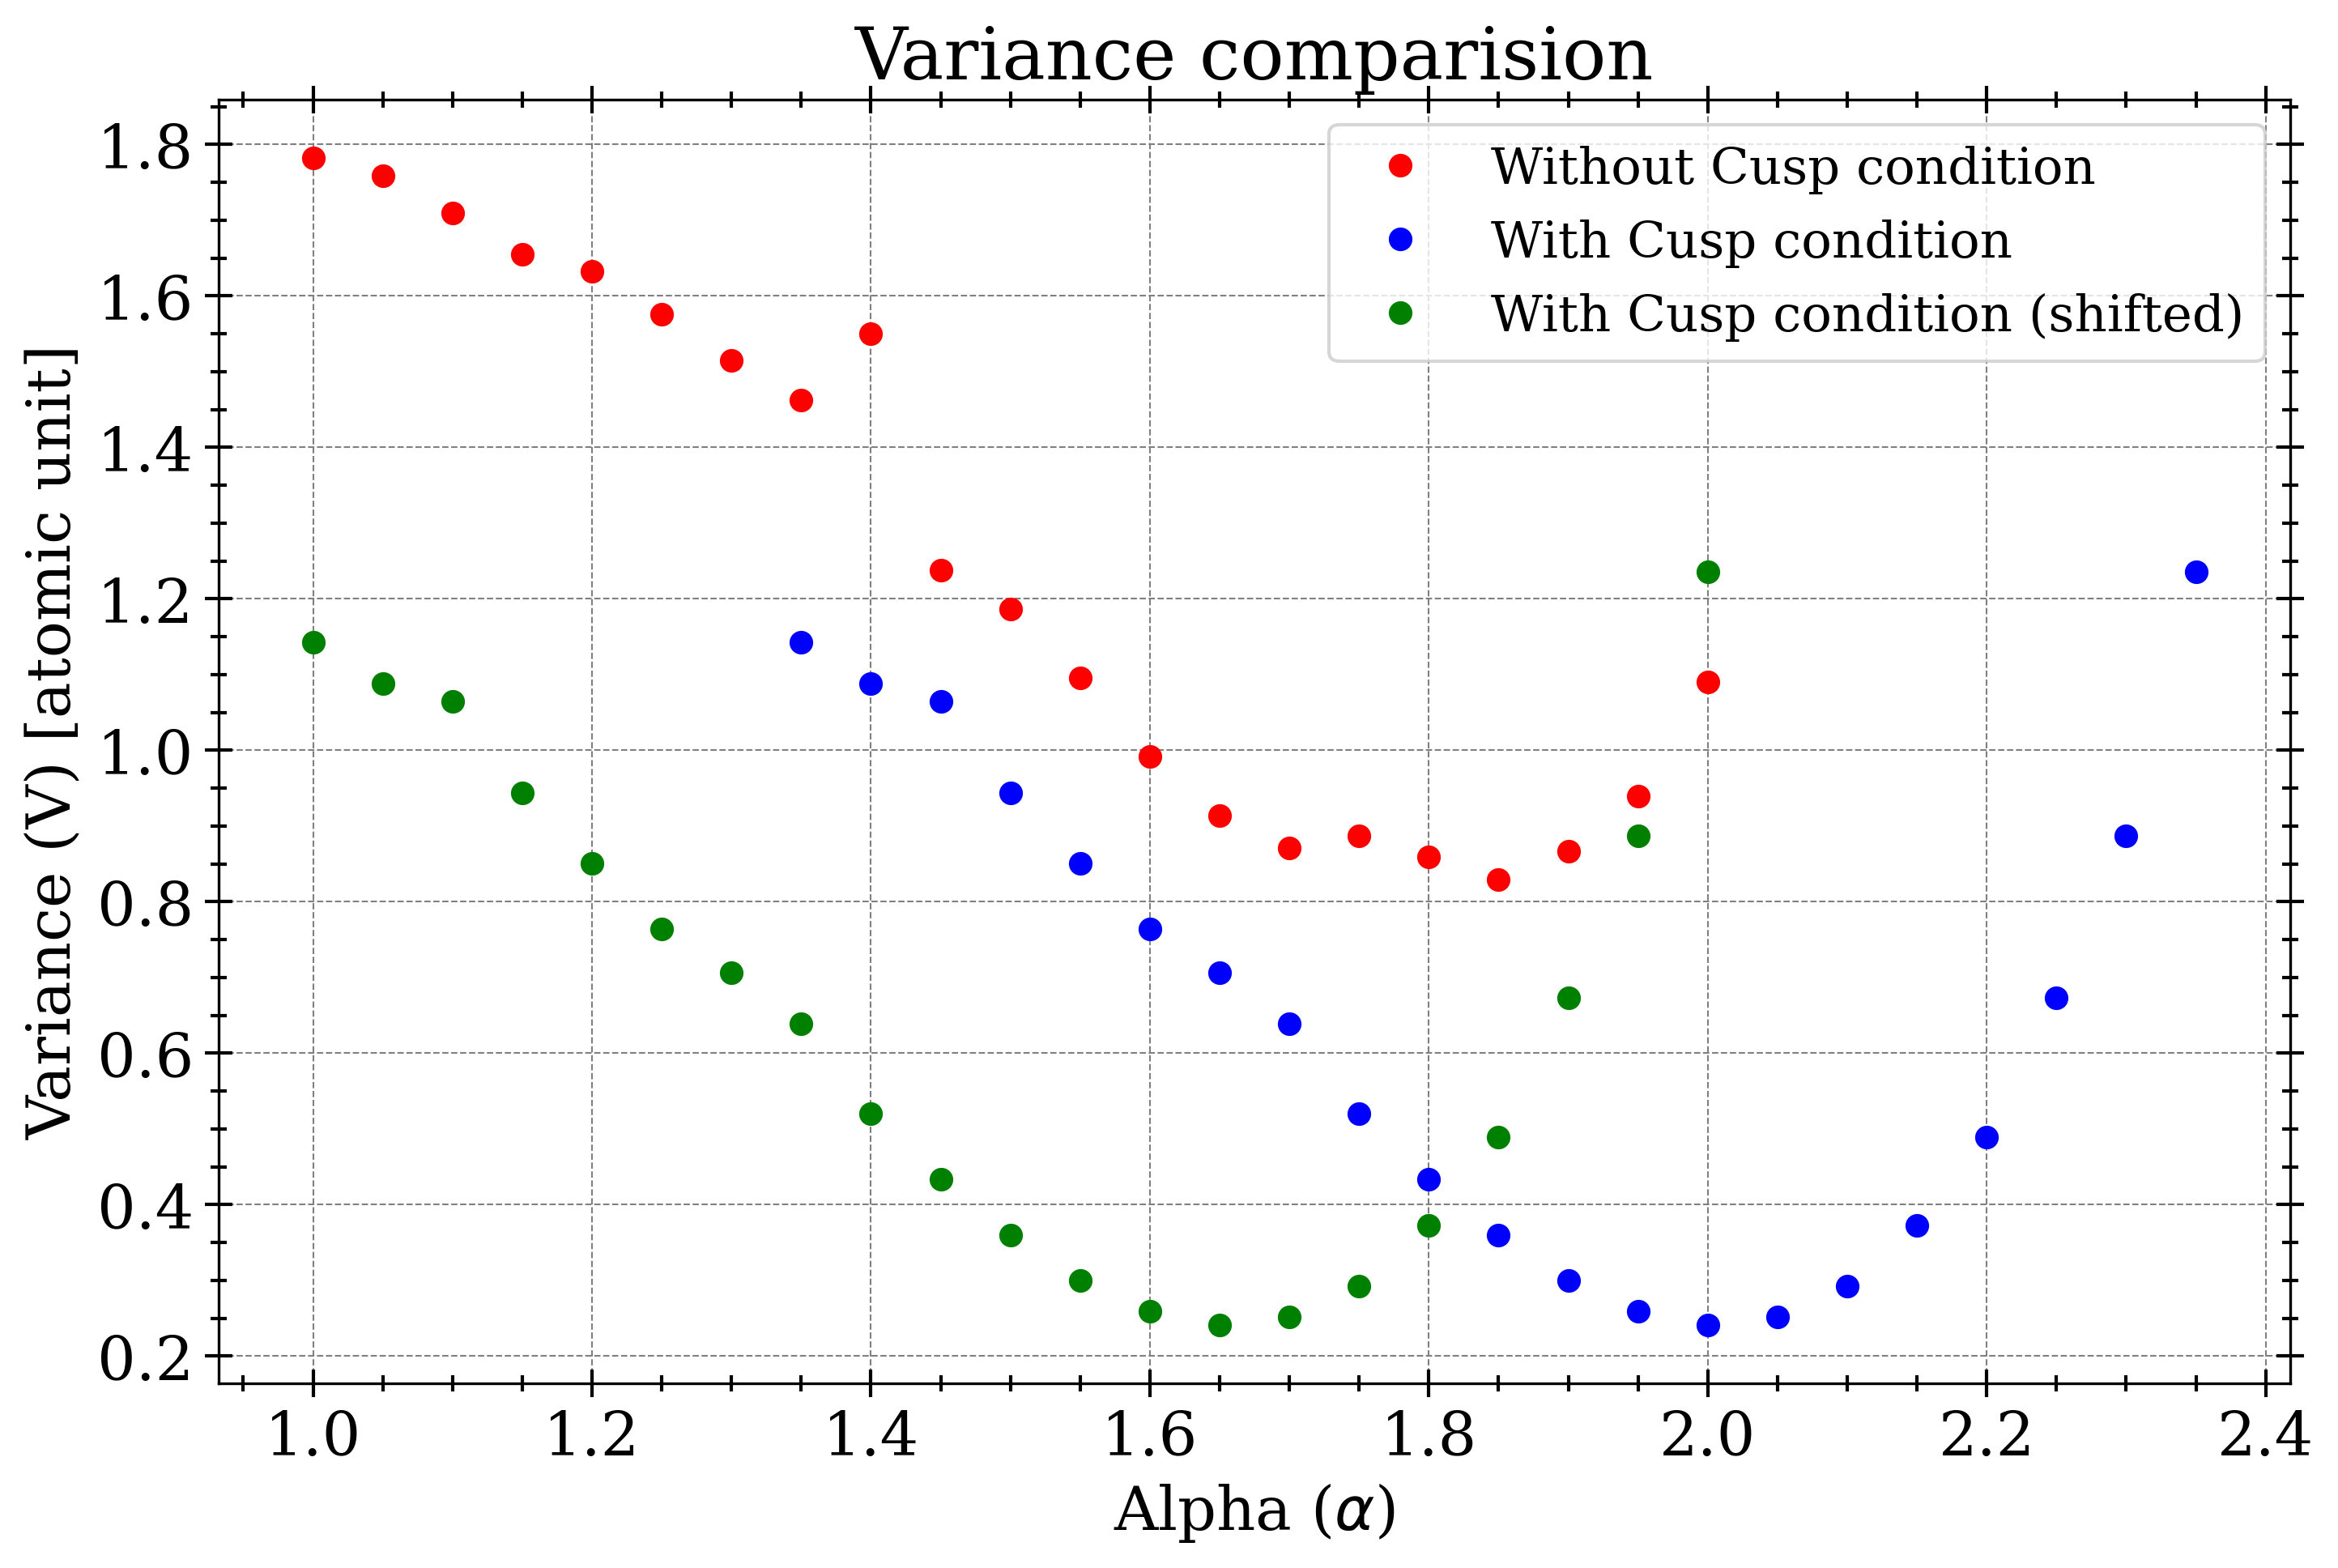

In [13]:
plt.plot(a_val, var, 'ro',label='Without Cusp condition')
plt.plot(a_val_c[:21], var_c[:21], 'bo',label='With Cusp condition')
plt.plot(np.array(a_val_c[:21])-0.35, var_c[:21], 'go',label='With Cusp condition (shifted)')
plt.xlabel(r'Alpha ($\alpha$)')
plt.ylabel('Variance (V) [atomic unit]')
plt.title('Variance comparision')
plt.legend()
plt.show()

From above we can see that with cusp condition we are getting less variance than without cusp condition.

we shifted the graph in order to properly compare the variance at optimal point.

## Data

In [21]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df = pd.DataFrame({r'Parameter $\alpha$': a_val, r'Mean Energy $<H>$': energy, r' Variance $\sigma^{2}$': var})

print('Without Cusp condition')
df

Without Cusp condition


,Parameter $\alpha$,Mean Energy $<H>$,Variance $\sigma^{2}$
0,1.00,-2.376186,1.782717
1,1.05,-2.440304,1.758329
2,1.10,-2.503013,1.709141
3,1.15,-2.558659,1.655578
4,1.20,-2.609508,1.632830
5,1.25,-2.656223,1.575677
6,1.30,-2.696976,1.514633
7,1.35,-2.735243,1.462522
8,1.40,-2.765827,1.550459
9,1.45,-2.791914,1.238224


In [15]:
# Convert DataFrame to LaTeX table string
latex_table = df.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 Parameter \$\textbackslash alpha\$ &  Mean Energy \$<H>\$ &   Variance \$\textbackslash sigma\textasciicircum \{2\}\$ \\
\midrule
           1.000000 &          -2.376186 &                1.782717 \\
           1.050000 &          -2.440304 &                1.758329 \\
           1.100000 &          -2.503013 &                1.709141 \\
           1.150000 &          -2.558659 &                1.655578 \\
           1.200000 &          -2.609508 &                1.632830 \\
           1.250000 &          -2.656223 &                1.575677 \\
           1.300000 &          -2.696976 &                1.514633 \\
           1.350000 &          -2.735243 &                1.462522 \\
           1.400000 &          -2.765827 &                1.550459 \\
           1.450000 &          -2.791914 &                1.238224 \\
           1.500000 &          -2.812620 &                1.186735

In [22]:
# making the dataframe contaning the mean energy and varivance for each value of alpha
df_c = pd.DataFrame({r'Parameter $\alpha$': a_val_c, r'Mean Energy $<H>$': energy_c, r' Variance $\sigma^{2}$': var_c})

print('With Cusp condition')
df_c

With Cusp condition


,Parameter $\alpha$,Mean Energy $<H>$,Variance $\sigma^{2}$
0,1.35,-2.355603,1.143211
1,1.40,-2.422791,1.088185
2,1.45,-2.496143,1.064856
3,1.50,-2.549392,0.943368
4,1.55,-2.603672,0.850977
5,1.60,-2.655623,0.763831
6,1.65,-2.698987,0.706781
7,1.70,-2.738049,0.638892
8,1.75,-2.770954,0.520268
9,1.80,-2.798873,0.433170


In [17]:
# Convert DataFrame to LaTeX table string
latex_table_c = df_c.to_latex(
    index=False,           # Exclude index column
    header=True,           # Include column headers
    float_format="%.6f",   # Format float values
    caption="Sample Table", # Add caption
    label="tab:sample_table", # Add label for referencing
    column_format="lcc"    # Align columns (left, center, center)
)

# Print the LaTeX table string
print(latex_table_c)

\begin{table}
\centering
\caption{Sample Table}
\label{tab:sample_table}
\begin{tabular}{lcc}
\toprule
 Parameter \$\textbackslash alpha\$ &  Mean Energy \$<H>\$ &   Variance \$\textbackslash sigma\textasciicircum \{2\}\$ \\
\midrule
           1.350000 &          -2.355603 &                1.143211 \\
           1.400000 &          -2.422791 &                1.088185 \\
           1.450000 &          -2.496143 &                1.064856 \\
           1.500000 &          -2.549392 &                0.943368 \\
           1.550000 &          -2.603672 &                0.850977 \\
           1.600000 &          -2.655623 &                0.763831 \\
           1.650000 &          -2.698987 &                0.706781 \\
           1.700000 &          -2.738049 &                0.638892 \\
           1.750000 &          -2.770954 &                0.520268 \\
           1.800000 &          -2.798873 &                0.433170 \\
           1.850000 &          -2.820759 &                0.359569